# Visualización de información textual

Autor: Eric S. Tellez <eric.tellez@infotec.mx> <br/>


## Introducción
Recordemos que el objetivo de la disciplina de Recuperación de Información es facilitar el acceso a las personas a grandes cúmulos de información, de tal forma que seamos capaces de encontrar la información sobre la que se realizan consultas. En ese espíritu, el agrupamiento (clustering) y la visualización son de gran ayuda para obtener información de valor.

Dado que los documentos suelen estar representados en muy alta dimensión, es prácticamente imposible visualizar y aprender sobre la estructura de una base de datos. Esto último lo podemos realizar mediante transformaciones que nos permitan obtener dimensiones que permitan la visualización de las estructuras subyacientes, i.e., dimensiones 2 y 3.

Ya en la Unidad 6 se veía la pertinencia de visualización para la selección visual de parámetros de un algoritmo de agrupamiento. En específico se utilizó el algoritmo de reducción no lineal UMAP. En esta unidad se verán alternativas adicionales y sus características.

## Proyecciones a baja dimensión
La visualización es una de las herramientas más importantes para el entendimiento de una colección de documentos. El problema viene en que no somos capaces de pensar o visualizar elementos en alta dimensión, entonces para visualizar es necesario proyectar los datos a 2D o 3D. La idea es que información de valor sea _evidente_ a nuestros ojos.

En particular, podemos considerar dos formas primordiales de proyecciones: lineales y no-lineales. Las proyecciones lineales son eficientes de calcular pero solo podrán capturar información lineal en la proyección. Un ejemplo paradigmático es Principal Compontent Analysis ([PCA](https://en.wikipedia.org/wiki/Principal_component_analysis)), que es ampliamente usado en ciencia de datos y que la gran mayoría de la paquetería para análisis de datos lo implementará ([PCA en sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), [PCA en Julia](https://github.com/JuliaStats/MultivariateStats.jl)). En particular, cuando los datos podrían no ser proyectados de manera adecuada con transformaciones lineales, entonces se hace necesario el uso de transformaciones no lineales. En este caso podemos tener en cuenta Kernel PCA ([KPCA](https://en.wikipedia.org/wiki/Kernel_principal_component_analysis)) cuya _no linearidad_ es manejada por funciones kernel, i.e., realizando una proyección no-linear mediante el kernel antes de aplicar PCA.

La familia de métodos _manifold learning_ también pueden ser una opción. En estos casos, en lugar de analizar las componentes de los vectores, se hace uso de la matriz de afinidad $A$, i.e., matriz de distancias $d(u, v) \forall u, v \in X$, o el grafo de todos los $k$ vecinos cercanos $G$. En particular, estos métodos intentarán crear representaciones vectoriales de baja dimensión que repreduzcan hasta cierto nivel de precisión dicha matriz $A$ o $G$, esto es, que las relaciones topológicas se preserven. Entre estos métodos podemos encontrar [Isomap](https://en.wikipedia.org/wiki/Isomap), [tSNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), [UMAP](https://umap-learn.readthedocs.io/en/latest/), [TSNE](https://github.com/lejon/TSne.jl).

En particular, es posible encontrar implementaciones de ellos en [sklearn](https://scikit-learn.org/stable/modules/manifold.html) y [UMAP](https://umap-learn.readthedocs.io/en/latest/) para Python; en Julia [ManifoldLearning.jl](https://github.com/wildart/ManifoldLearning.jl) y [SimSearchManifoldLearning.jl](https://github.com/sadit/SimSearchManifoldLearning.jl), donde también se puede acceder a una implementación eficiente de UMAP. 


# Ejemplo

In [1]:
using Pkg
Pkg.activate(".")

using SimilaritySearch, SimSearchManifoldLearning, TextSearch, ManifoldLearning, MultivariateStats, TSne,
    StatsBase, Clustering, StatsPlots, LinearAlgebra, HypertextLiteral, JLD2, JSON, DataFrames

  Activating project at `~/Cursos/IR-2024/Unidades`


## Creación de índice y lectura de datos

In [2]:
function create_index(db)
    dist = NormalizedCosineDistance()
    index = SearchGraph(; dist, db)
    index!(index)
    optimize_index!(index, MinRecall(0.9))
    index
end

include("read_datasets.jl")

E = let
    corpus, _ = read_news()
    Xtrain = load("data/spanish-twitter-news-and-opinions-top25-68.train--sbert-multi-L12-v2.h5", "emb")::Matrix{Float32}
    index = create_index(MatrixDatabase(Xtrain))
    (; corpus, index)
end

nothing

append_items! sp=5911, ep=6167, n=6167, BeamSearch
  bsize: Int32 5
  Δ: Float32 1.1f0
  maxvisits: Int64 1106
, 2024-01-10T13:11:06.952
append_items! sp=7196, ep=7452, n=7452, BeamSearch
  bsize: Int32 5
  Δ: Float32 1.1f0
  maxvisits: Int64 1106
, 2024-01-10T13:11:07.185


# Reducción de dimensión con UMAP

  0.450767 seconds (243.74 k allocations: 16.888 MiB, 72.79% compilation time)


*** computing graph
*** layout embedding SpectralLayout
*** fit ab / embedding
*** opt embedding


 23.074910 seconds (15.30 M allocations: 14.730 GiB, 2.22% gc time, 55.35% compilation time)


UMAP construction time cost report:
- fuzzy graph: 0.297062375
- embedding init: 7.340026794
- embedding opt: 4.377228017



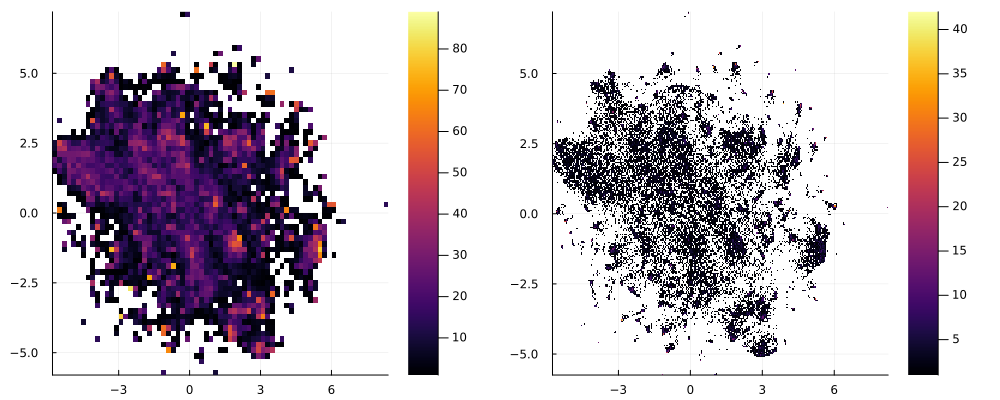

In [3]:
let
    @time umap = fit(UMAP, E.index; maxoutdim=2, k=15, neg_sample_rate=5, layout=SpectralLayout(), n_epochs=100, tol=1e-4)
    X = predict(umap)
    A = histogram2d(view(X, 1, :), view(X, 2, :), bins=100)
    B = histogram2d(view(X, 1, :), view(X, 2, :), bins=300)
    plot(A, B, size=(1000, 400))
end

  0.131491 seconds (30.25 k allocations: 3.923 MiB)


*** computing graph
*** layout embedding RandomLayout
*** fit ab / embedding
*** opt embedding


  3.319137 seconds (115.53 k allocations: 52.230 MiB, 2.47% compilation time)


UMAP construction time cost report:
- fuzzy graph: 0.080958771
- embedding init: 0.000386466
- embedding opt: 3.022469328



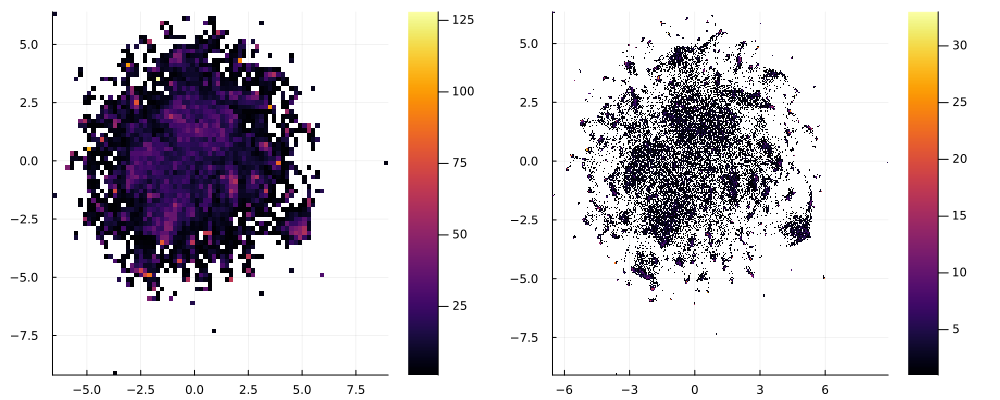

In [4]:
let
    @time umap = fit(UMAP, E.index; maxoutdim=2, k=15, neg_sample_rate=5, layout=RandomLayout(), n_epochs=100, tol=1e-4)
    X = predict(umap)
    A = histogram2d(view(X, 1, :), view(X, 2, :), bins=100)
    B = histogram2d(view(X, 1, :), view(X, 2, :), bins=300)
    plot(A, B, size=(1000, 400))
end

## Principal Component Analysis

  4.117145 seconds (3.84 M allocations: 302.351 MiB, 2.39% gc time, 94.98% compilation time)
  0.069688 seconds (100.84 k allocations: 51.174 MiB, 68.97% compilation time)


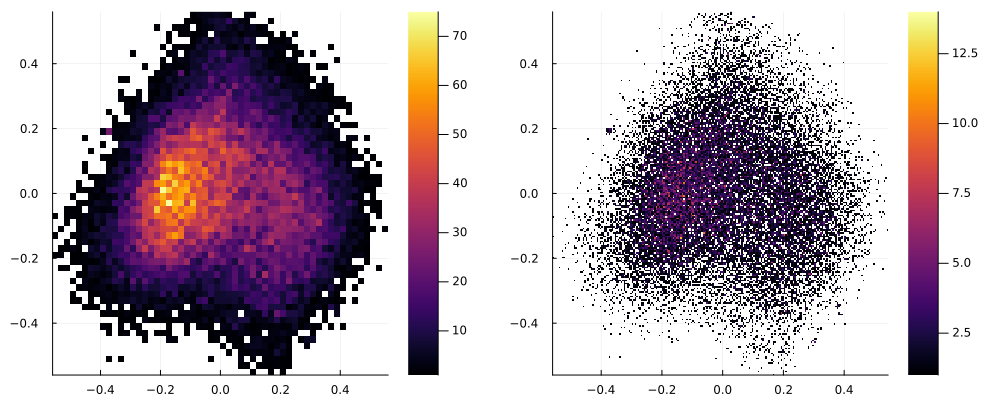

In [5]:
let M = database(E.index).matrix
    @time pca = fit(PCA, M; maxoutdim=2)
    @time X = predict(pca, M)
    A = histogram2d(view(X, 1, :), view(X, 2, :), bins=100)
    B = histogram2d(view(X, 1, :), view(X, 2, :), bins=300)
    plot(A, B, size=(1000, 400))
end

In [6]:
#=  #Muy lento
    let M = database(E.index).matrix
    @time kpca = fit(KernelPCA, M; maxoutdim=2)
    @time X = predict(kpca, M)
    A = histogram2d(view(X, 1, :), view(X, 2, :), bins=100)
    B = histogram2d(view(X, 1, :), view(X, 2, :), bins=300)
    plot(A, B, size=(1000, 400))
end=#

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/vnCY0/src/ProgressMeter.jl:626
Computing t-SNE 100%|████████████████████████████████████| Time: 0:00:57
  KL_divergence:  5.3733 (warmup)


 95.334852 seconds (7.64 M allocations: 3.048 GiB, 0.40% gc time, 9.13% compilation time)


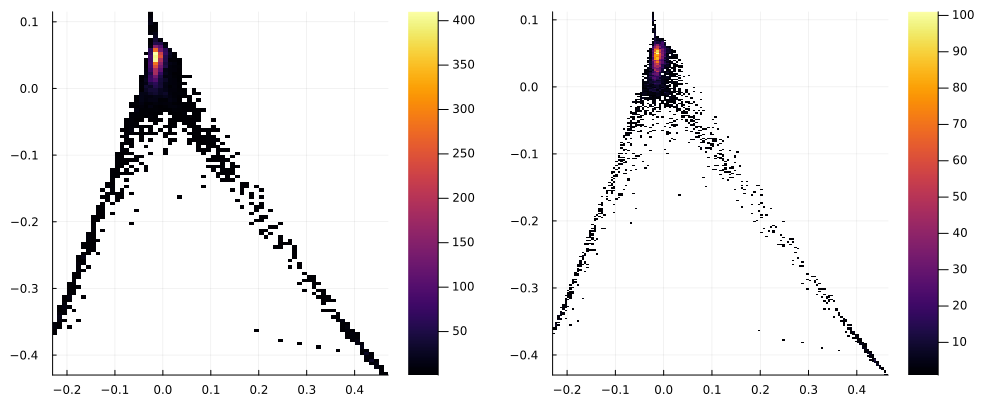

In [7]:
# TSne uses rows as observations and columns as features
let M_ = rand(database(E.index), 8192) # it takes 20 min with the full dataset
    M = permutedims(MatrixDatabase(M_).matrix)
    # M = permutedims(MatrixDatabase(database(E.index)).matrix)
    # tsne(X, ndim, reduce_dims_pca, max_iter, perplexit; [keyword arguments])
    @time X = tsne(M, 2, 50, 100, 30; progress=true)
    x, y = view(X, :, 1), view(X, :, 2)    
    A = histogram2d(x, y, bins=100)
    B = histogram2d(x, y, bins=300)
    plot(A, B, size=(1000, 400))
end



# Actividades
- Si usa Julia, revise el paquete `SimilaritySearch.jl`: <https://github.com/sadit/SimilaritySearch.jl> y <https://github.com/sadit/SimSearchManifoldLearning.jl>.
- Si usa Python, revise el paquete UMAP: <https://umap-learn.readthedocs.io/en/latest/>.
- Prepare la colección de `noticias` o el `emojispace` con la representación semántica de sbert, compare los resultados con  la representación basada en bolsa de palabras (primeras unidades del curso). Reproducir las operaciones y el análisis de este notebook con estos datos.
- Reporte su notebook con una comparación de tiempos y calidadades.

# Bibliografía

- [@AW2019] Amid, E., & Warmuth, M. K. (2019). TriMap: Large-scale dimensionality reduction using triplets. arXiv preprint arXiv:1910.00204.
- [@LV2017] Lee, J. A., & Verleysen, M. (2007). Nonlinear dimensionality reduction (Vol. 1). New York: Springer.
- [@MHM2018] McInnes, L., Healy, J., & Melville, J. (2018). Umap: Uniform manifold approximation and projection for dimension reduction. arXiv preprint arXiv:1802.03426.
- [@SKL2011] Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, E. (2011). Scikit-learn: Machine learning in Python. the Journal of machine Learning research, 12, 2825-2830.
- [@SPA2019] Soto, A. J., Przybyła, P., & Ananiadou, S. (2019). Thalia: semantic search engine for biomedical abstracts. Bioinformatics, 35(10), 1799-1801.
- [@SS2021] Sharma, K. K., & Seal, A. (2021). Spectral embedded generalized mean based k-nearest neighbors clustering with S-distance. Expert Systems with Applications, 169, 114326.
- [@VMH2018] Van der Maaten, L., & Hinton, G. (2008). Visualizing data using t-SNE. Journal of machine learning research, 9(11).
- [@YCC2020] Yu, Q., Chen, K. H., & Chen, J. J. (2020, September). Using a set of triangle inequalities to accelerate k-means clustering. In International Conference on Similarity Search and Applications (pp. 297-311). Springer, Cham.